In [1]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

Mounted at /content/drive


In [2]:
main_path = '/content/drive/MyDrive/MyProject/Moonboard/Videos/' # To modify with your path
my_path = '/content/drive/MyDrive/MyProject/Moonboard/' # To modify with your path

## Create Dataset

In [3]:
import torch
training = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Label generation

In [4]:
sequence_length = 40

model_path = my_path + "ClimbingTransformer_2.ptk"

In [5]:

from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

classes = [str(i) for i in range(sequence_length)]
all_labels = [tokenizer(c) for c in classes]

vocab = build_vocab_from_iterator(all_labels)#, specials=["<token>", "<unk>"])
# vocab.set_default_index(vocab["<unk>"])
print(vocab.get_stoi())

    

def data_process(raw_text_iter):
    data = [torch.tensor(vocab(item), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))
    
inv_map = {v: k for k, v in vocab.get_stoi().items()}

ntokens = len(vocab)

{'7': 37, '6': 36, '21': 14, '38': 32, '19': 11, '39': 33, '17': 9, '16': 8, '22': 15, '4': 34, '2': 12, '1': 1, '25': 18, '18': 10, '13': 5, '9': 39, '37': 31, '0': 0, '11': 3, '10': 2, '33': 27, '12': 4, '36': 30, '15': 7, '20': 13, '8': 38, '28': 21, '14': 6, '26': 19, '27': 20, '29': 22, '3': 23, '30': 24, '31': 25, '5': 35, '23': 16, '32': 26, '34': 28, '24': 17, '35': 29}


In [6]:
import pickle
import random
import math
import torch.nn as nn

import numpy as np
import glob
import re
import torch

class MyDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.sequence_length = sequence_length
    
    def __getitem__(self, idx):
        points = torch.randn(sequence_length, 2).to(device)
        points, indices = torch.sort(points, 0)
        order = torch.arange(0, sequence_length).unsqueeze(1).to(device)
        print('inputs_coords', points.shape)
        print('output_token', order.shape)
        joined = torch.cat([points, order], dim=1).to(device)
        ds = [(x[0:2], x[2].long()) for x in list(joined)]
        #random points have label 1 and grid poitns label 0
        dl = torch.utils.data.DataLoader(ds, batch_size=self.sequence_length, shuffle=True)
        x, y = iter(dl).next()
        return x, y
        
    
    def __len__(self):
        return 1000

# mds = MyDataset()
# vds = mds

In [7]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
#         self.pos_encoder = PositionalEncoding(ninp, side_length, dropout)
        self.encoder_layers = [TransformerEncoderLayer(ninp, nhead, nhid, dropout) for _ in range(nlayers)]
        self.layers = nn.Sequential(*self.encoder_layers)
        self.encoder = nn.Linear(2, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
#         src = self.pos_encoder(src)
        for i, layer in enumerate(self.encoder_layers):
            src = layer(src, src_mask)
            
        output = self.decoder(src)
        return output

In [8]:
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, dropout=0.1, max_len=30*32):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         label = self.pe[:sz_label, :]
#         axial_list = []
#         current = 0
#         for s in sz_images_list:
# #             axial_list.append(self.axial[current:current+s, :, :])
#             axial_list.append(self.axial[:s, :, :])
#             current += s
        
#         joined_axial = torch.cat(axial_list, 0)
#         joined = torch.cat((label, joined_axial[:, :, :]), 0)
#         return self.dropout(x + joined)


In [9]:
# nlayers = 8 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
# nhead = 8 # the number of heads in the multiheadattention models
# emsize = nhead*80 # embedding dimension
# nhid = nhead*100 # the dimension of the feedforward network model in nn.TransformerEncoder
# dropout = 0.002 # the dropout value
# model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

# # model
# src_mask = torch.zeros(sequence_length, sequence_length).to(device)

## Data Loading

In [10]:
# batch_size = 20
# training_loader = torch.utils.data.DataLoader(mds, batch_size=batch_size, shuffle=True)
# validation_loader = torch.utils.data.DataLoader(vds, batch_size=1, shuffle=False)

# My Data Loading: holds informations

In [11]:
import numpy as np
import pandas as pd
import json
import itertools

move_seq_path = my_path + 'MoveSeqs/'
holds_seq_path = my_path + 'HoldsSeqs/'

In [12]:
worksheet = pd.read_csv(my_path + 'videos.csv')
worksheet = worksheet.iloc[:,1:]

In [13]:
nb_decimals = 2
MAX_LENGTH = 17

def standardize_df(df):
    return df.round(nb_decimals)

def convert_df_into_tensor(df):
    """Concatenates all the rows of a dataframe into a big list of strings.
    WARNING: the column names are not registered, so the order has to be implicitly respected"""
    df_list = torch.empty(df.shape)

    for i in range(df.shape[0]):
        df_list[i] = (torch.Tensor(df.iloc[i]))

    # df_list = list(itertools.chain.from_iterable(df_list))
    
    return df_list

def generate_token_sequences(nb_seqs, length = MAX_LENGTH):
  token_sequence = torch.linspace(0,length-1, length, dtype=torch.int64)
  return token_sequence.repeat(nb_seqs, 1)

position_vocabulary = {i/(10**nb_decimals) : i for i in range(10**nb_decimals)}
position_vocabulary[-1] = 10**nb_decimals
token_vocabulary = {f'hold_{i}' : i for i in range(MAX_LENGTH + 1)} # the last one is the additional token that will be used for padding
inverse_token_vocabulary = {i: f'hold_{i}' for i in range(MAX_LENGTH + 1)}

def generate_input_sequences(target, nb_perms = 2):
  input_seqs = []
  output_seqs = []
  input_token_seqs = generate_token_sequences(nb_seqs = nb_perms, length = target.shape[0])
  output_token_seqs = []
  for n in range(nb_perms):
    full_input = torch.cat((target, input_token_seqs[n].view(-1,1)),1)
    shuffled_input = np.random.permutation(full_input)

    input_seqs.append((torch.Tensor(shuffled_input[:,:2])))
    output_token_seqs.append(torch.Tensor(shuffled_input[:,2:]).view(-1))
    output_seqs.append(target)
    

  return input_seqs, output_seqs, torch.vstack(output_token_seqs)

def generate_dummy_sequence(dummy_char = -1):
  return torch.full((MAX_LENGTH, 2), fill_value = dummy_char)

In [14]:
def prepare_data(sheet, nb_perms = 30):
  """Returns 2 lists of arrays containing all sequences of holds and moves for each climb"""
  input_seqs = []
  output_seqs = []
  output_token_seqs = []

  inputs_tokens = torch.Tensor()
  outputs_tokens = torch.Tensor()

  for i in range(sheet.shape[0]):
    if i%10 == 0:
      print(f'Preparing data for video {i}/{sheet.shape[0] - 1}')
    video = sheet.iloc[i,0]
    try:
      target = pd.read_csv(move_seq_path + video + '_MOVE_SEQ.csv').iloc[:,2:]

      target_coords = target.iloc[:,:2]
      target_tokens = target.iloc[:,2]
    except FileNotFoundError:
      continue

    if(target_coords.shape[0] > 4):
      try:
        target_coords = standardize_df(target_coords)
        target_coords["x"].replace(position_vocabulary, inplace = True)
        target_coords["y"].replace(position_vocabulary, inplace = True)

        target_coords_tensor = convert_df_into_tensor(target_coords)
        
        input_seqs_video, output_seqs_video, output_token_seqs_video = generate_input_sequences(target_coords_tensor, nb_perms=nb_perms)
        input_seqs += input_seqs_video
        output_seqs += output_seqs_video

        # Copy the shuffled token sequences and add them to the list
        input_token_seqs = generate_token_sequences(nb_perms)
        input_token_seqs[:,output_token_seqs_video.shape[1]:] = MAX_LENGTH # the last ones are padded with the additional token
        outputs_token_seqs = torch.clone(input_token_seqs)
        outputs_token_seqs[:,:output_token_seqs_video.shape[1]] = output_token_seqs_video
        

        inputs_tokens = torch.cat((inputs_tokens, input_token_seqs))
        outputs_tokens = torch.cat((outputs_tokens, outputs_token_seqs))

      except TypeError:
          continue

  # Pad the sequences
  dummy_seq = generate_dummy_sequence()
  outputs = output_seqs + [dummy_seq]
  inputs = input_seqs + [dummy_seq]

  inputs_coords = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=position_vocabulary[-1])
  outputs_coords = torch.nn.utils.rnn.pad_sequence(outputs, batch_first=True, padding_value=position_vocabulary[-1])


  # Remove the dummy sequence
  nb_seqs = inputs_coords.shape[0] - 1
  inputs_coords = inputs_coords[:nb_seqs]
  outputs_coords = outputs_coords[:nb_seqs]

  return inputs_coords, outputs_coords, inputs_tokens, outputs_tokens

# inputs_coords, outputs_coords, inputs_tokens, outputs_tokens = prepare_data(worksheet, nb_perms=50)
# print(f'Prepared sequences of shape {inputs_coords.shape}')

In [15]:
validation_index = 4

class HoldsDataset(torch.utils.data.Dataset):
    def __init__(self, val=False):
        self.nb_perms = 50
        if val:
          self.inputs_coords, self.outputs_coords, self.inputs_tokens, self.outputs_tokens = prepare_data(worksheet[:validation_index], nb_perms=self.nb_perms)
        else:
          self.inputs_coords, self.outputs_coords, self.inputs_tokens, self.outputs_tokens = prepare_data(worksheet[validation_index:], nb_perms=self.nb_perms)

        print(f'Prepared sequences of shape {self.inputs_coords.shape}')
    def __getitem__(self, idx):
        joined = torch.cat([self.inputs_coords[idx], self.outputs_tokens[idx].unsqueeze(1)], dim=1).to(device)
        ds = [(x[0:2], x[2].long()) for x in list(joined)]
        #random points have label 1 and grid poitns label 0
        dl = torch.utils.data.DataLoader(ds, batch_size=self.inputs_coords.shape[0], shuffle=False)
        x, y = iter(dl).next()
        return x, y
        
    
    def __len__(self):
        return self.inputs_coords.shape[0]

mds = HoldsDataset(val=False)
vds = HoldsDataset(val=True)

batch_size = 10
training_loader = torch.utils.data.DataLoader(mds, batch_size=batch_size, shuffle=False)
validation_loader = torch.utils.data.DataLoader(vds, batch_size=1, shuffle=False)

Preparing data for video 0/15
Preparing data for video 10/15
Prepared sequences of shape torch.Size([800, 17, 2])
Preparing data for video 0/3
Prepared sequences of shape torch.Size([200, 17, 2])


In [16]:
nlayers = 8 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8 # the number of heads in the multiheadattention models
emsize = nhead*80 # embedding dimension
nhid = nhead*100 # the dimension of the feedforward network model in nn.TransformerEncoder
dropout = 0.002 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

# model
src_mask = torch.zeros(MAX_LENGTH, MAX_LENGTH).to(device)

# Beginning of training

In [17]:
def accuracy(predicted_logits, reference):
    """Compute the ratio of correctly predicted labels"""
    labels = torch.argmax(predicted_logits, 1)
    correct_predictions = labels.eq(reference)
    return correct_predictions.sum().float() / correct_predictions.nelement()

criterion = nn.CrossEntropyLoss()
for x,y in training_loader:
    data = x.transpose(0,1).to(device)
    targets = y.transpose(0,1).to(device).long()
    output = model(data, src_mask)
    print(data.shape, targets.shape)
    print("output.shape ", output.shape)
    loss = criterion(output.reshape(-1, ntokens), targets.reshape(-1))
    acc = accuracy(output.reshape(-1, ntokens), targets.reshape(-1)).item()
    print("loss ", loss, " acc ", acc)
    break

torch.Size([17, 10, 2]) torch.Size([17, 10])
output.shape  torch.Size([17, 10, 40])
loss  tensor(5.1284, device='cuda:0', grad_fn=<NllLossBackward0>)  acc  0.0


In [18]:
targets[:,0]

tensor([ 8,  4,  0,  3,  2,  5,  6,  1,  7, 17, 17, 17, 17, 17, 17, 17, 17],
       device='cuda:0')

In [19]:
def get_lr(num_steps, current_max_lr):
    lr = num_steps / (250 * 40000)
    return min(current_max_lr, lr)

In [20]:
import time

criterion = nn.CrossEntropyLoss()
lr = 4.5*10**-4 # learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.96), eps=10**(-8), weight_decay=4.5**-2)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.lr_num_decreases = 0

def train(num_steps, current_max_lr, best_loss):
    model.train() # Turn on the train mode
    total_loss = 0.
    total_acc = 0.
    start_time = time.time()
    for batch, (x, y) in enumerate(training_loader):
        lr = get_lr(num_steps, current_max_lr)
        optimizer.param_groups[0]['lr'] = lr
        
        data = x.transpose(0,1).to(device)
        targets = y.transpose(0,1).to(device).long()
        optimizer.zero_grad()    
        output = model(data, src_mask)
        
        loss = criterion(output.reshape(-1, ntokens), targets.reshape(-1))
        loss.backward()
        
        if num_steps < 5000:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        num_steps += 1

        total_loss += loss.item()
        total_acc += accuracy(output.reshape(-1, ntokens), targets.reshape(-1)).item()
        
        log_interval = max(200, math.floor(len(training_loader) / 4))
        if batch % (10 * log_interval) == 0 and batch > 0:
            torch.save(model.to('cpu').state_dict(), model_path)
            model.to(device)
            print("Modeled saved")
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            cur_acc = total_acc / log_interval
            total_loss = total_acc = 0.
            print("num_stepes ", num_steps, " curr_loss ", cur_loss, " best_loss ", best_loss, ", ", cur_loss - best_loss)
            
            if cur_loss < best_loss:
                best_loss = cur_loss
            
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | ms/batch {:5.2f} | '
                  'loss {:5.4f} | acc {:5.2f}'.format(
                    epoch, batch, len(training_loader), optimizer.param_groups[0]['lr'],
                    elapsed * 1000 / log_interval,
                    cur_loss, cur_acc))
            total_loss = 0
            start_time = time.time()
            
    return num_steps, current_max_lr, best_loss
            
def evaluate(eval_model, loader):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    total_data_points = 0
    acc_mean = 0.
    total = 0
    
    with torch.no_grad():
        for batch, (x, y) in enumerate(loader):
            data = x.transpose(0,1).to(device)
            targets = y.transpose(0,1).to(device).long()    
            output = model(data, src_mask)

            loss = criterion(output.reshape(-1, ntokens), targets.reshape(-1))
            acc_mean += accuracy(output.view(-1, ntokens), targets.reshape(-1))
            total += 1
            total_loss += len(data) * loss.item()
            total_data_points += len(data)
        print("Test Accuracy ", 100. * acc_mean.item() / total)
    return total_loss / total_data_points

In [21]:
# load existing model
# model.load_state_dict(torch.load(model_path, map_location=device))

In [22]:
if training:
    best_loss = float('inf')
    best_val_loss = float("inf")
    epochs = 100 # 300 The number of epochs
    num_steps = 1
    current_max_lr = 10**-4 # 4.5*10**-4
    scheduler = [75, 115]
    
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # if epoch in scheduler:
        #     current_max_lr /= 5
        num_steps, current_max_lr, best_loss = train(num_steps, current_max_lr, best_loss)
        val_loss = evaluate(model, validation_loader)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
              'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                         val_loss, math.exp(min(val_loss, 10))))
        print('-' * 89)
        # if val_loss - best_val_loss > 0.01:
        #     print("Reducing lr")
        #     current_max_lr /= 1.5
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print("model saved")
            torch.save(model.to('cpu').state_dict(), model_path)
        model = model.to(device)

Test Accuracy  51.470462799072266
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  3.56s | valid loss  1.71 | valid ppl     5.53
-----------------------------------------------------------------------------------------
model saved
Test Accuracy  51.470619201660156
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  3.47s | valid loss  1.42 | valid ppl     4.15
-----------------------------------------------------------------------------------------
model saved
Test Accuracy  55.882354736328125
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  4.82s | valid loss  1.31 | valid ppl     3.70
-----------------------------------------------------------------------------------------
model saved
Test Accuracy  54.411842346191406
------------------------------------------------------------------

# Check results

In [23]:
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [48]:
import seaborn as sns
def visualize_results(prediction, targets):
  plt.plot(prediction.cpu(),targets.cpu(), linestyle='', marker='o', markersize=4)
  sns.kdeplot(x=prediction.view(-1).cpu(), y=targets.view(-1).cpu(),cmap="Reds", shade=True)
  plt.xlim([-1,18])
  plt.ylim([-1,18])
  plt.plot([-1,18],[-1,18], 'g')
  plt.xlabel('Predicted output',fontsize=14)
  plt.ylabel('Real output',fontsize=14)
  plt.show()


 accuracy  0.6470588445663452
[[3, 0], [0, 0], [6, 7], [1, 3], [5, 3], [2, 7], [4, 8], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]


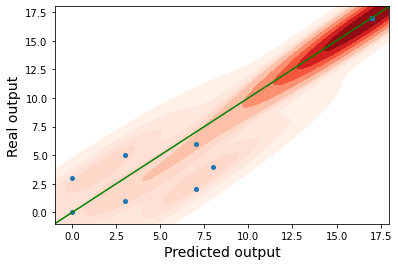

 accuracy  0.6470588445663452
[[3, 0], [4, 8], [2, 7], [1, 3], [6, 7], [0, 0], [5, 3], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[0, 0], [3, 0], [6, 7], [5, 3], [1, 3], [2, 7], [4, 8], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[0, 0], [1, 3], [5, 3], [6, 7], [4, 8], [2, 7], [3, 0], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[0, 0], [1, 3], [6, 7], [4, 8], [2, 7], [5, 3], [3, 0], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[1, 3], [5, 3], [2, 7], [0, 0], [3, 0], [6, 7], [4, 8], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[2, 7], [0, 0], [5, 3], [1, 3], [3

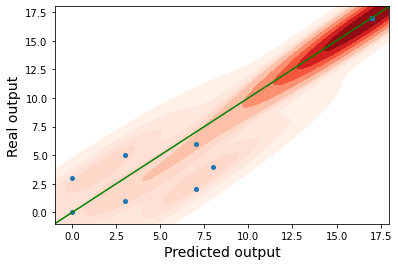

 accuracy  0.6470588445663452
[[6, 7], [0, 0], [3, 0], [5, 3], [2, 7], [4, 8], [1, 3], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[3, 0], [4, 8], [2, 7], [5, 3], [6, 7], [1, 3], [0, 0], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[2, 7], [0, 0], [3, 0], [1, 3], [6, 7], [5, 3], [4, 8], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[4, 8], [2, 7], [1, 3], [0, 0], [6, 7], [5, 3], [3, 0], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[6, 7], [2, 7], [0, 0], [1, 3], [5, 3], [3, 0], [4, 8], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[2, 7], [5, 3], [0, 0], [6, 7], [4

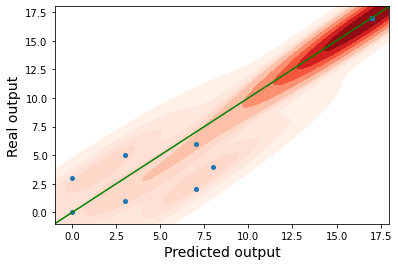

 accuracy  0.6470588445663452
[[6, 7], [4, 8], [5, 3], [2, 7], [0, 0], [3, 0], [1, 3], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[3, 0], [6, 7], [0, 0], [2, 7], [4, 8], [1, 3], [5, 3], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[6, 7], [5, 3], [4, 8], [3, 0], [1, 3], [2, 7], [0, 0], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[6, 7], [0, 0], [1, 3], [4, 8], [3, 0], [5, 3], [2, 7], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[2, 7], [3, 0], [4, 8], [6, 7], [0, 0], [5, 3], [1, 3], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.6470588445663452
[[3, 0], [1, 3], [0, 0], [5, 3], [2

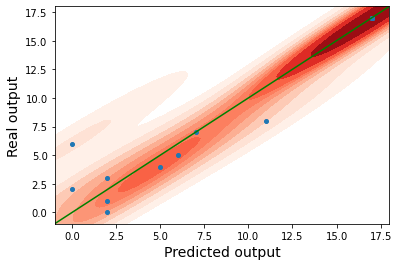

 accuracy  0.529411792755127
[[6, 0], [8, 11], [1, 2], [7, 7], [0, 2], [2, 0], [3, 2], [4, 5], [5, 6], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[1, 2], [6, 0], [0, 2], [8, 11], [2, 0], [3, 2], [4, 5], [7, 7], [5, 6], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[1, 2], [6, 0], [3, 2], [0, 2], [5, 6], [4, 5], [8, 11], [7, 7], [2, 0], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[5, 6], [0, 2], [1, 2], [6, 0], [2, 0], [8, 11], [3, 2], [4, 5], [7, 7], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[5, 6], [2, 0], [0, 2], [1, 2], [8, 11], [6, 0], [3, 2], [4, 5], [7, 7], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[8, 11], [4, 5], [1, 2], [6, 0], [5, 6], [3, 2], [0, 2]

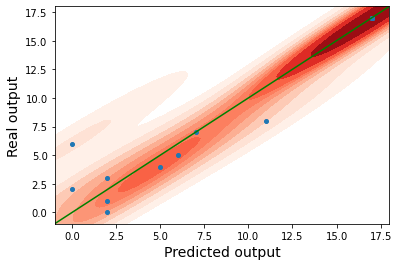

 accuracy  0.529411792755127
[[4, 5], [2, 0], [6, 0], [8, 11], [1, 2], [5, 6], [7, 7], [3, 2], [0, 2], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[0, 2], [8, 11], [4, 5], [1, 2], [3, 2], [7, 7], [2, 0], [5, 6], [6, 0], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[6, 0], [5, 6], [4, 5], [2, 0], [8, 11], [7, 7], [1, 2], [3, 2], [0, 2], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[6, 0], [8, 11], [7, 7], [1, 2], [5, 6], [3, 2], [0, 2], [4, 5], [2, 0], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[2, 0], [4, 5], [8, 11], [7, 7], [6, 0], [1, 2], [3, 2], [0, 2], [5, 6], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[1, 2], [5, 6], [4, 5], [2, 0], [7, 7], [3, 2], [6, 0],

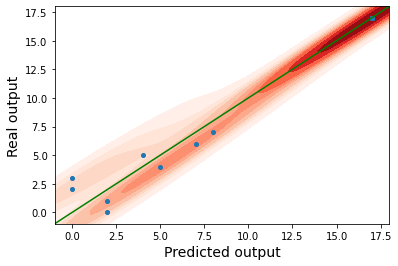

 accuracy  0.529411792755127
[[2, 0], [5, 4], [3, 0], [4, 5], [1, 2], [7, 8], [0, 2], [6, 7], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[7, 8], [4, 5], [3, 0], [6, 7], [2, 0], [1, 2], [5, 4], [0, 2], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[6, 7], [7, 8], [2, 0], [1, 2], [0, 2], [3, 0], [5, 4], [4, 5], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[5, 4], [7, 8], [0, 2], [3, 0], [1, 2], [6, 7], [4, 5], [2, 0], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[5, 4], [2, 0], [7, 8], [1, 2], [4, 5], [3, 0], [6, 7], [0, 2], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[6, 7], [5, 4], [1, 2], [2, 0], [4, 5], [0, 2], [7

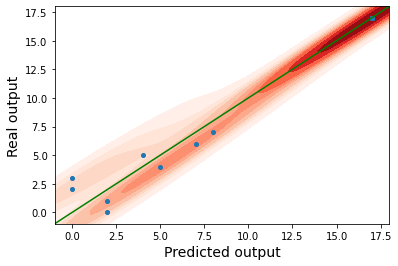

 accuracy  0.529411792755127
[[3, 0], [5, 4], [1, 2], [0, 2], [4, 5], [7, 8], [6, 7], [2, 0], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[3, 0], [0, 2], [5, 4], [4, 5], [2, 0], [7, 8], [1, 2], [6, 7], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[7, 8], [1, 2], [3, 0], [2, 0], [5, 4], [6, 7], [4, 5], [0, 2], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[2, 0], [1, 2], [4, 5], [0, 2], [3, 0], [5, 4], [7, 8], [6, 7], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[6, 7], [7, 8], [0, 2], [5, 4], [1, 2], [2, 0], [3, 0], [4, 5], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[4, 5], [1, 2], [6, 7], [7, 8], [0, 2], [5, 4], [3

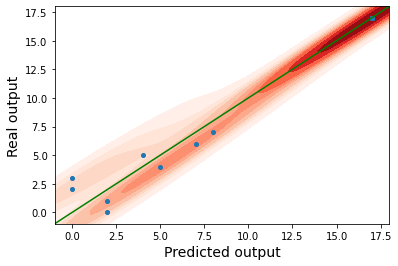

 accuracy  0.529411792755127
[[6, 7], [4, 5], [0, 2], [3, 0], [7, 8], [5, 4], [1, 2], [2, 0], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[2, 0], [6, 7], [0, 2], [1, 2], [4, 5], [7, 8], [3, 0], [5, 4], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[0, 2], [4, 5], [3, 0], [6, 7], [5, 4], [7, 8], [2, 0], [1, 2], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[4, 5], [2, 0], [6, 7], [1, 2], [0, 2], [5, 4], [3, 0], [7, 8], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[5, 4], [2, 0], [0, 2], [1, 2], [4, 5], [6, 7], [3, 0], [7, 8], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17], [17, 17]]
 accuracy  0.529411792755127
[[5, 4], [7, 8], [6, 7], [1, 2], [4, 5], [0, 2], [3

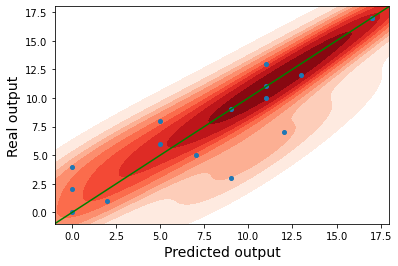

 accuracy  0.3529411852359772
[[1, 2], [4, 0], [13, 11], [12, 13], [11, 11], [10, 11], [9, 9], [6, 5], [0, 0], [2, 0], [5, 7], [8, 5], [7, 12], [3, 9], [17, 17], [17, 17], [17, 17]]
 accuracy  0.3529411852359772
[[5, 7], [4, 0], [2, 0], [10, 11], [12, 13], [1, 2], [11, 11], [13, 11], [3, 9], [7, 12], [0, 0], [8, 5], [9, 9], [6, 5], [17, 17], [17, 17], [17, 17]]
 accuracy  0.3529411852359772
[[5, 7], [7, 12], [1, 2], [12, 13], [0, 0], [9, 9], [10, 11], [6, 5], [13, 11], [4, 0], [3, 9], [8, 5], [11, 11], [2, 0], [17, 17], [17, 17], [17, 17]]
 accuracy  0.3529411852359772
[[10, 11], [8, 5], [1, 2], [4, 0], [13, 11], [3, 9], [2, 0], [5, 7], [11, 11], [12, 13], [6, 5], [0, 0], [9, 9], [7, 12], [17, 17], [17, 17], [17, 17]]
 accuracy  0.3529411852359772
[[0, 0], [2, 0], [8, 5], [12, 13], [9, 9], [10, 11], [5, 7], [1, 2], [13, 11], [3, 9], [4, 0], [6, 5], [11, 11], [7, 12], [17, 17], [17, 17], [17, 17]]
 accuracy  0.3529411852359772
[[10, 11], [5, 7], [9, 9], [3, 9], [4, 0], [12, 13], [13, 11

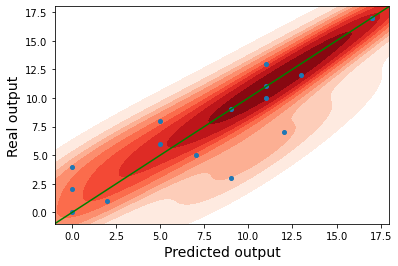

 accuracy  0.3529411852359772
[[5, 7], [3, 9], [8, 5], [0, 0], [12, 13], [1, 2], [6, 5], [9, 9], [10, 11], [7, 12], [13, 11], [2, 0], [11, 11], [4, 0], [17, 17], [17, 17], [17, 17]]
 accuracy  0.3529411852359772
[[1, 2], [5, 7], [6, 5], [11, 11], [7, 12], [10, 11], [3, 9], [8, 5], [12, 13], [13, 11], [2, 0], [4, 0], [9, 9], [0, 0], [17, 17], [17, 17], [17, 17]]
 accuracy  0.3529411852359772
[[12, 13], [6, 5], [4, 0], [10, 11], [13, 11], [9, 9], [11, 11], [8, 5], [5, 7], [7, 12], [2, 0], [3, 9], [0, 0], [1, 2], [17, 17], [17, 17], [17, 17]]
 accuracy  0.3529411852359772
[[0, 0], [13, 11], [9, 9], [11, 11], [12, 13], [3, 9], [7, 12], [1, 2], [6, 5], [5, 7], [2, 0], [4, 0], [10, 11], [8, 5], [17, 17], [17, 17], [17, 17]]
 accuracy  0.3529411852359772
[[11, 11], [6, 5], [8, 5], [13, 11], [10, 11], [4, 0], [3, 9], [12, 13], [7, 12], [1, 2], [2, 0], [9, 9], [5, 7], [0, 0], [17, 17], [17, 17], [17, 17]]
 accuracy  0.3529411852359772
[[8, 5], [6, 5], [7, 12], [11, 11], [0, 0], [9, 9], [4, 0], 

In [49]:
mds.noise_factor = 0.
vds.noise_factor = 0.
criterion = nn.CrossEntropyLoss()

validation_loader = torch.utils.data.DataLoader(vds, batch_size=1, shuffle=False)
plot_every = 20
i = 0
for x,y in validation_loader:
    data = x.transpose(0,1).to(device)
    targets = y.transpose(0,1).to(device).long()
    output = model(data, src_mask)
    prediction = torch.argmax(output, 2)
    # print(data.shape, targets.shape)
    # print("output.shape ", output.shape)
    loss = criterion(output.reshape(-1, ntokens), targets.reshape(-1))
    acc = accuracy(output.reshape(-1, ntokens), targets.reshape(-1)).item()
    print('='*160)
    print(" accuracy ", acc)
    print([[targets[i].item(), prediction[i].item()] for i in range(targets.shape[0])])
    if (i % plot_every) == 0:
      visualize_results(prediction, targets)
    i += 1

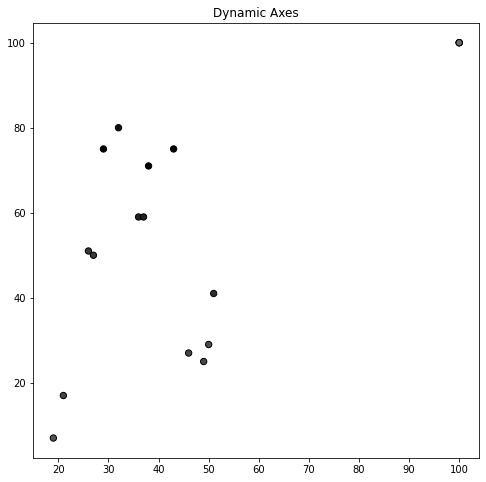

In [25]:
# import numpy as np
# from matplotlib.animation import FuncAnimation
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d
# # %matplotlib qt

# size = 1000

# prediction = torch.argmax(output, 2)

# fig = plt.figure(figsize = (8, 8))
# # axes = plt.axes(projection = '3d')
# axes = plt.axes()
# plt.title("Dynamic Axes")

# predicted_order = [ ((x/sequence_length).item(), (x/sequence_length).item(), (x/sequence_length).item(), 1) for x in prediction]

# axes.scatter( x[0][:, 0].cpu(), x[0][:, 1].cpu(), s=40, edgecolors='k', facecolors=predicted_order, marker="o")
# # axes.scatter3D( x[0][:, 0], x[0][:, 1], x[0][:, 2], s=20, edgecolors=prediction_colors, facecolors=prediction_colors)

# def func(angle):
#     pass
    
# # interval = 100
# # ani = FuncAnimation(fig, func, interval)
# plt.show()

In [26]:
# targets

tensor([[11],
        [ 0],
        [ 7],
        [12],
        [ 6],
        [13],
        [ 9],
        [ 1],
        [ 4],
        [10],
        [ 2],
        [ 5],
        [ 8],
        [ 3],
        [17],
        [17],
        [17]], device='cuda:0')

In [27]:
# prediction

tensor([[11],
        [ 0],
        [12],
        [13],
        [ 5],
        [11],
        [ 9],
        [ 2],
        [ 0],
        [11],
        [ 0],
        [ 7],
        [ 5],
        [ 9],
        [17],
        [17],
        [17]], device='cuda:0')